<a href="https://colab.research.google.com/github/sanaeaba/Recommende_system_coursera/blob/master/NeuFM_Coursera.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fast-ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 1.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from fast_ml.model_development import train_valid_test_split
from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, Dropout, Dense, BatchNormalization,concatenate,Multiply,Dot
from tensorflow.keras import regularizers
#from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

In [ ]:
data = pd.read_csv("merged_coursera_datase.csv")
data

,course_id,user_id,rating,Sentiment,course_difficulty
0,289,8507,2,0,0
1,289,15643,2,1,0
2,289,3474,2,2,0
3,289,7221,3,0,0
4,289,8776,3,0,0
...,...,...,...,...,...
20117,210,1060,4,0,2
20118,210,4906,4,0,2
20119,210,838,4,2,2
20120,210,695,4,0,2


In [ ]:
from sklearn.preprocessing import LabelEncoder
course_encoder = LabelEncoder()
user_encoder = LabelEncoder()

data['course_id'] = course_encoder.fit_transform(data.course_id)
data['user_id'] = user_encoder.fit_transform(data.user_id)
data

,course_id,user_id,rating,Sentiment,course_difficulty
0,289,8507,2,0,0
1,289,15643,2,1,0
2,289,3474,2,2,0
3,289,7221,3,0,0
4,289,8776,3,0,0
...,...,...,...,...,...
20117,210,1060,4,0,2
20118,210,4906,4,0,2
20119,210,838,4,2,2
20120,210,695,4,0,2


In [ ]:
#categorical data
categorical_cols = ['Sentiment','course_difficulty']
#import pandas as pd
data = pd.get_dummies(data, columns = categorical_cols)
data

,course_id,user_id,rating,Sentiment_0,Sentiment_1,Sentiment_2,course_difficulty_0,course_difficulty_1,course_difficulty_2,course_difficulty_3
0,289,8507,2,1,0,0,1,0,0,0
1,289,15643,2,0,1,0,1,0,0,0
2,289,3474,2,0,0,1,1,0,0,0
3,289,7221,3,1,0,0,1,0,0,0
4,289,8776,3,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
20117,210,1060,4,1,0,0,0,0,1,0
20118,210,4906,4,1,0,0,0,0,1,0
20119,210,838,4,0,0,1,0,0,1,0
20120,210,695,4,1,0,0,0,0,1,0


In [ ]:
data['user_metadata'] = data.apply(lambda row: ''.join(row['Sentiment_0':'Sentiment_2'].astype(str)), axis=1)
data = data.drop(columns=['Sentiment_0', 'Sentiment_1', 'Sentiment_2'])
data['course_metadata'] = data.apply(lambda row: ''.join(row['course_difficulty_0':'course_difficulty_3'].astype(str)), axis=1)
data = data.drop(columns=['course_difficulty_0', 'course_difficulty_1', 'course_difficulty_2','course_difficulty_3'])

In [ ]:
data

,course_id,user_id,rating,user_metadata,course_metadata
0,289,8507,2,100,1000
1,289,15643,2,010,1000
2,289,3474,2,001,1000
3,289,7221,3,100,1000
4,289,8776,3,100,1000
...,...,...,...,...,...
20117,210,1060,4,100,0010
20118,210,4906,4,100,0010
20119,210,838,4,001,0010
20120,210,695,4,100,0010


In [ ]:
data['course_metadata'] = course_encoder.fit_transform(data.course_metadata)
data['user_metadata'] = user_encoder.fit_transform(data.user_metadata)
data

,course_id,user_id,rating,user_metadata,course_metadata
0,289,8507,2,2,3
1,289,15643,2,1,3
2,289,3474,2,0,3
3,289,7221,3,2,3
4,289,8776,3,2,3
...,...,...,...,...,...
20117,210,1060,4,2,1
20118,210,4906,4,2,1
20119,210,838,4,0,1
20120,210,695,4,2,1


In [ ]:
num_users = len(data.user_id.unique())
num_courses = len(data.course_id.unique())
num_course_metadata = data.course_metadata.max()
num_user_metadata = data.user_metadata.max()
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(data, target = 'rating', train_size=0.7, valid_size=0.1, test_size=0.2)

In [ ]:
latent_dim = 18

# Define inputs
course_input = Input(shape=[1],name='course-input')
user_input = Input(shape=[1], name='user-input')
course_metadata_input = Input(1,name='course-metadata-input')
user_metadata_input = Input(1,name='user-metadata-input')

# MLP Embeddings
course_embedding_mlp = Embedding( num_courses + 1, latent_dim, name='course-embedding-mlp')(course_metadata_input)
course_vec_mlp = Flatten(name='flatten-course-mlp')(course_embedding_mlp)

user_embedding_mlp = Embedding(num_users + 1, latent_dim, name='user-embedding-mlp')(user_metadata_input)
user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)

# MF Embeddings
course_embedding_mf = Embedding(num_courses + 1, latent_dim, name='course-embedding-mf')(course_input)
course_vec_mf = Flatten(name='flatten-course-mf')(course_embedding_mf)

user_embedding_mf = Embedding(num_users + 1, latent_dim, name='user-embedding-mf')(user_input)
user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

# MLP layers
concat = concatenate([course_vec_mlp, user_vec_mlp])
concat_dropout = Dropout(0.2)(concat)
fc_1 = Dense(100, name='fc-1', activation='relu')(concat_dropout)
fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
fc_1_dropout = Dropout(0.2)(fc_1_bn)
fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
fc_2_dropout = Dropout(0.2)(fc_2_bn)

# Prediction from both layers
pred_mlp = Dense(10, name='pred-mlp', activation='relu')(fc_2_dropout)
#pred_mf = concatenate([course_vec_mf, user_vec_mf])
#pred_mf = Multiply()([course_vec_mf, user_vec_mf])
#pred_mf = Dot(axes=1)([course_vec_mf, user_vec_mf])
pred_mf = course_vec_mf * user_vec_mf
combine_mlp_mf = concatenate([pred_mf, pred_mlp], name='combine-mlp-mf')

# Final prediction
result = Dense(1, name='result', activation='relu')(combine_mlp_mf)

model = Model([user_input, course_input,course_metadata_input, user_metadata_input], result)
#model.compile(loss='mse', optimizer='adam')
#model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='mean_absolute_error')
#model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='mean_squared_error' ,metrics=['accuracy'])
#image= SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
model.summary()

Model: "model_28"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 course-metadata-input (Inp  [(None, 1)]                  0         []                            
 utLayer)                                                                                         
                                                                                                  
 user-metadata-input (Input  [(None, 1)]                  0         []                            
 Layer)                                                                                           
                                                                                                  
 course-embedding-mlp (Embe  (None, 1, 18)                5706      ['course-metadata-input[0][0]'
 dding)                                                             ]                      

In [ ]:
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Multiply, Dot, Dropout, BatchNormalization
import keras

latent_dim = 18

# Define inputs
course_input = Input(shape=[1], name='course-input')
user_input = Input(shape=[1], name='user-input')
course_metadata_input = Input(shape=[1], name='course-metadata-input')
user_metadata_input = Input(shape=[1], name='user-metadata-input')

# MLP Embeddings
course_embedding_mlp = Embedding(num_courses + 1, latent_dim, name='course-embedding-mlp')(course_metadata_input)
course_vec_mlp = Flatten(name='flatten-course-mlp')(course_embedding_mlp)

user_embedding_mlp = Embedding(num_users + 1, latent_dim, name='user-embedding-mlp')(user_metadata_input)
user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)

# MF Embeddings
course_embedding_mf = Embedding(num_courses + 1, latent_dim, name='course-embedding-mf')(course_input)
course_vec_mf = Flatten(name='flatten-course-mf')(course_embedding_mf)

user_embedding_mf = Embedding(num_users + 1, latent_dim, name='user-embedding-mf')(user_input)
user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

# MLP layers
concat_mlp = Concatenate(name='concat-mlp')([course_vec_mlp, user_vec_mlp])
fc_1 = Dense(100, name='fc-1', activation='relu')(concat_mlp)
fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_bn)
fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)

# MF prediction
pred_mf = Multiply(name='pred-mf')([course_vec_mf, user_vec_mf])

# MLP prediction
pred_mlp = Dense(10, name='pred-mlp', activation='relu')(fc_2_bn)

# Combine MF and MLP predictions
combine_mlp_mf = Concatenate(name='combine-mlp-mf')([pred_mf, pred_mlp])

# Final prediction
result = Dense(1, name='result', activation='relu')(combine_mlp_mf)

model = Model([user_input, course_input, course_metadata_input, user_metadata_input], result)

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='mean_squared_error')

# Print the model summary
model.summary()

Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 course-metadata-input (Inp  [(None, 1)]                  0         []                            
 utLayer)                                                                                         
                                                                                                  
 user-metadata-input (Input  [(None, 1)]                  0         []                            
 Layer)                                                                                           
                                                                                                  
 course-embedding-mlp (Embe  (None, 1, 18)                5706      ['course-metadata-input[0][0]'
 dding)                                                             ]                      

In [ ]:
from sklearn.metrics import mean_absolute_error
history = model.fit([X_train.user_id, X_train.course_id, X_train.course_metadata, X_train.user_metadata], y_train, epochs=65, batch_size=100, validation_data=([X_valid.user_id, X_valid.course_id, X_valid.course_metadata, X_valid.user_metadata], y_valid))
y_hat = model.predict([X_test.user_id, X_test.course_id, X_test.course_metadata, X_test.user_metadata])
y_true = y_test

Epoch 1/65
141/141 [==============================] - 2s 16ms/step - loss: 0.0046 - val_loss: 0.8338
Epoch 2/65
141/141 [==============================] - 2s 14ms/step - loss: 0.0045 - val_loss: 0.8500
Epoch 3/65
141/141 [==============================] - 2s 13ms/step - loss: 0.0050 - val_loss: 0.8475
Epoch 4/65
141/141 [==============================] - 2s 14ms/step - loss: 0.0052 - val_loss: 0.8364
Epoch 5/65
141/141 [==============================] - 2s 11ms/step - loss: 0.0047 - val_loss: 0.8406
Epoch 6/65
141/141 [==============================] - 1s 8ms/step - loss: 0.0046 - val_loss: 0.8312
Epoch 7/65
141/141 [==============================] - 1s 7ms/step - loss: 0.0051 - val_loss: 0.8180
Epoch 8/65
141/141 [==============================] - 1s 8ms/step - loss: 0.0049 - val_loss: 0.8228
Epoch 9/65
141/141 [==============================] - 1s 7ms/step - loss: 0.0044 - val_loss: 0.8172
Epoch 10/65
141/141 [==============================] - 1s 8ms/step - loss: 0.0047 - val_loss: 0

In [ ]:
!pip install recmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 99.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.5/227.5 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 88.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 13.7 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.15.0
    Uninstalling plotly-5.15.0:
      Successfully uninstalled plotly-5.15.0
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2
ERROR: pip's dependency resolver does

# **--------------before--------------**

In [ ]:
import recmetrics
MAE = mean_absolute_error(y_true, y_hat)
print("MAE: ", MAE)
print("MSE: ", recmetrics.mse(y_true,y_hat))
print("RMSE: ", recmetrics.rmse(y_true,y_hat))

MAE:  0.6360326151225878
MSE:  0.7722154245867274
RMSE:  0.8787578873539216


# **--------------after--------------**

In [ ]:
import recmetrics
MAE = mean_absolute_error(y_true, y_hat)
print("MAE: ", MAE)
print("MSE: ", recmetrics.mse(y_true,y_hat))
print("RMSE: ", recmetrics.rmse(y_true,y_hat))

MAE:  0.7024316122813254
MSE:  0.7653660208025217
RMSE:  0.8748519993704773


In [ ]:
!pip install -U matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


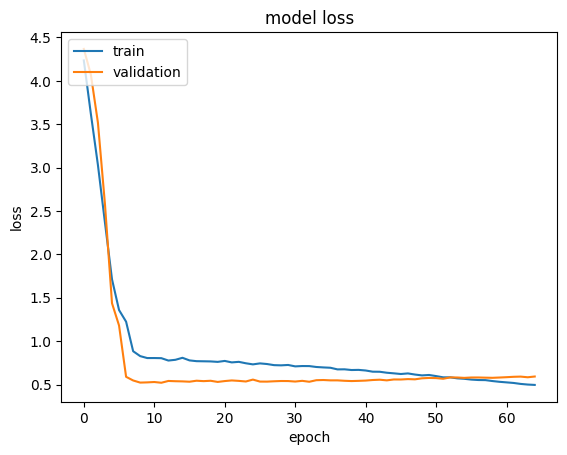

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()